# Project 2: Web Traffic Analysis
**This is the second of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
In this project your task is to analyze a stream of log entries. A log entry consists of an [IP address](https://en.wikipedia.org/wiki/IP_address) and a [domain name](https://en.wikipedia.org/wiki/Domain_name). For example, a log line may look as follows:

`192.168.0.1 somedomain.dk`

One log line is the result of the event that the domain name was visited by someone having the corresponding IP address. Your task is to analyze the traffic on a number of domains. Counting the number of unique IPs seen on a domain doesn't correspond to the exact number of unique visitors, but it is a good estimate.

Specifically, you should answer the following questions from the stream of log entries.

- How many unique IPs are there in the stream?
- How many unique IPs are there for each domain?
- How many times was IP X seen on domain Y? (for some X and Y provided at run time)

**The answers to these questions can be approximate!**

You should also try to answer one or more of the following, more advanced, questions. The answers to these should also be approximate.

- How many unique IPs are there for the domains $d_1, d_2, \ldots$?
- How many times was IP X seen on domains $d_1, d_2, \ldots$?
- What are the X most frequent IPs in the stream?

You should use algorithms and data structures that you've learned about in the lectures, and you should provide your own implementations of these.

Furthermore, you are expected to:

- Document the accuracy of your answers when using algorithms that give approximate answers
- Argue why you are using certain parameters for your data structures

This notebook is in three parts. In the first part you are given an example of how to read from the stream (which for the purpose of this project is a remote file). In the second part you should implement the algorithms and data structures that you intend to use, and in the last part you should use these for analyzing the stream.

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You may modify this if you want to, but your solution should remain parametrized, so that your notebook can be run without having to consume the entire file.

In [1]:
import urllib

def stream(n):
    i = 0
    with urllib.request.urlopen("https://files.dtu.dk/fss/public/link/public/stream/read/traffic_2?linkToken=_DcyO-U3MjjuNzI-&itemName=traffic_2") as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            splitted = element.split("\t")
            yield splitted
            i += 1
            if i == n:
                break

In [2]:
STREAM_SIZE = 10
web_traffic_stream = stream(STREAM_SIZE)

In [3]:
# Let's see an example;
next(web_traffic_stream)

['186.99.192.116', 'python.org']

## Data structures

**There is the pseudo code of Hyperloglog algoritm in the link "https://en.wikipedia.org/wiki/HyperLogLog". From there we have implemented the code below. We have implemented Count Min Algortihm from the paper provided from the lecture slides link.**

Let's see if we have splitted correctly

In [4]:
for ip, domain in stream(STREAM_SIZE):
    print(ip + " " + domain)

186.99.192.116 python.org
202.152.82.171 wikipedia.org
130.126.231.205 python.org
116.142.112.214 pandas.pydata.org
113.124.204.127 python.org
143.30.183.87 wikipedia.org
138.74.228.219 python.org
56.120.106.87 wikipedia.org
189.119.55.225 wikipedia.org
180.110.73.101 wikipedia.org


## HyperLogLog

In [5]:
# Considerations, our indexes for data are from 0 to 2**m - 1, so adding 1 as the paper said is not needed

In [6]:
import numpy as np
from mmh3 import hash
from math import log, log2

class HyperLogLog():
    def __init__(self, m):
        self.m = m
        self.p = round(log2(m))
        self.table = np.zeros((2**self.p, 1), dtype = np.int32)
        self.alpha = {16 : 0.673, 32 : 0.697, 64 : 0.709} [self.m] if self.m <= 64 else 0.7213 / (1 + 1.079 / self.m) 
        self.dictio = {}
    
    def set_table (self, new_tab):
        self.table = new_tab
    
    def get_value(self, i, j):
        return self.table[i, j]
    
    def add(self, ip, domain):
        if domain not in self.dictio:
            self.dictio[domain] = len(self.dictio) + 1
            self.table = np.append(self.table, np.zeros((2**self.p, 1), dtype = np.int32), axis = 1)
        
        hash_value = feature_hash(ip, 2**self.m,  seed = 1)
        hash_value = (self.m - len(bin(hash_value) [2:])) * "0" + bin(hash_value)[2:]
        idx = int(hash_value[2 : 2 + self.p], 2)
        w = hash_value [2 + self.p : ]
        
        try:
            tmp = w.index("1") + 1
        except:
            tmp = 0
            
        self.table[idx, 0] = max(self.table[idx, 0], tmp)
        self.table[idx, self.dictio[domain]] = max(self.table[idx, self.dictio[domain]], tmp)
        
    def count(self):
        z = 0
        for i in range(2**self.p):
            z = z + 1 / 2 ** self.table[i, 0]
        z = 1 / z
        e = self.alpha * z * self.m * self.m
        
        
        # Paper considerations
        if e < 2.5 * self.m:
            v = sum(self.table[:, 0] == 0)
            if v != 0:
                e = self.m * log(self.m / v)
        
        if e > 2 ** self.m / 30:
            e = -2 ** 32 * log (1 - e / 2 ** self.m)
            
        return int(e)
    
    def count_domain(self, domain):
        try:
            dom = self.dictio[domain]
            z = 0
            for i in range(2**self.p):
                z = z + 1 / 2 ** self.table[i, dom]
            z = 1 / z
            e = self.alpha * z * self.m * self.m
        
        
            # Paper considerations
            if e < 2.5 * self.m:
                v = sum(self.table[:, dom] == 0)
                if v != 0:
                    e = self.m * log(self.m / v)
        
            if e > 2 ** self.m / 30:
                e = -2 ** 32 * log (1 - e / 2 ** self.m)
            
            return int(e)
        
        except:
            print("Written domain is not in the stream")
            
    def add_product (self, domains):
        resul = HyperLogLog(32)
        tmp = np.zeros((2**self.p, 1), dtype = np.int32)
        flag = 0
        
        for i in range(self.m):
            for j in domains:
                try:
                    tmp [i] = max(tmp[i], self.get_value(i, self.dictio[j]))
                except:
                    flag = 1
                    
            resul.set_table(tmp)
        
        if flag == 1:
            print("Some written domains are not in the stream")
        return resul

## Count Min

In [7]:
import numpy as np
from mmh3 import hash
import matplotlib.pyplot as plt  
import scipy
%matplotlib inline

def feature_hash(feature, dim, seed):
    return hash(feature, seed) % dim

**We are not using directly hash function, but we are using a function called feature_hash which actually enable us to use less memory. In that sense we have used this function throughout all project.**

585380


<BarContainer object of 100 artists>

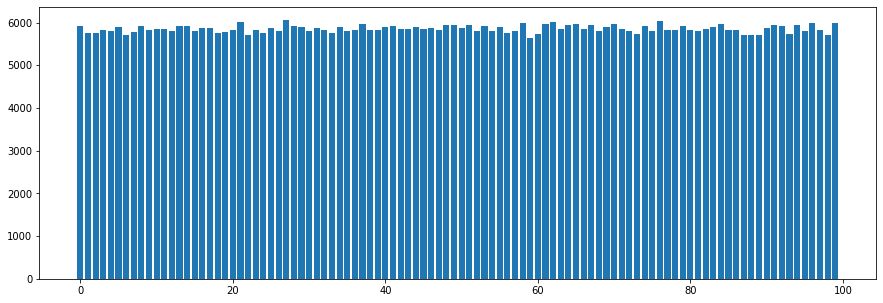

In [8]:
real = set()
for ip, domain in stream(600000):
    real.add(ip)

print(len(real))

counter = np.zeros((100, 1), dtype = np.int32)

for i in real:
    counter[feature_hash(i, 100, 1), 0] += 1
    
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.bar(range(100), counter[: ,0])

_**Hash function with dimension 100 uses less memory with difference of 2 digits. As we can see from the bar plot above, hash function did a great job. And it seems more or less uniformly distributed.**_

In [9]:
class Count_Min_Sketch ():
    
    def __init__ (self, num_hash_functions, width):
        self.num_hash_functions = num_hash_functions
        self.width = width
        self.sketch = np.zeros((self.num_hash_functions, self.width, 1), dtype = np.int32)
        self.dictio = {}
        
    def set_sketch(self, sketch):
        self.sketch = sketch
        
    def get_value (self, hash_funcion, column, domain):
        return self.sketch[hash_funcion, column, domain]
    
    def get_num_hash_function(self):
        return self.num_hash_functions
    
    def get_width (self):
        return self.width
    
    def add (self, ip, domain):
        
        if domain not in self.dictio:
            self.dictio[domain] = len(self.dictio) + 1
            self.sketch = np.append(self.sketch, np.zeros((self.num_hash_functions, self.width, 1), dtype = np.int32), axis = 2)

        for i in range(self.num_hash_functions):
            self.sketch[i, feature_hash(ip, self.width, seed = i), 0] += 1    
            self.sketch[i, feature_hash(ip, self.width, seed = i), self.dictio[domain]] += 1
            
    def count (self, X):
        respond = np.inf
        for i in range(self.num_hash_functions):
            respond = min(respond, self.sketch[i, feature_hash(X, self.width, seed = i), 0])
        
        return respond
    
    def count_domain (self, X, domain):
        respond = np.inf
        
        try:
            for i in range(self.num_hash_functions):
                respond = min(respond, self.sketch[i, feature_hash(X, self.width, seed = i), self.dictio[domain]])
        
        except:
            print("The written domain is not in the stream")
        
        return respond
    
    def add_product (self, domains):
        resul = Count_Min_Sketch(self.get_num_hash_function(), self.get_width())
        
        tmp = np.zeros((self.get_num_hash_function(), self.get_width(), 1), dtype = np.int32)
        flag = 0
        
        for i in range(self.get_num_hash_function()):
            for j in range(self.get_width()):
                for k in domains:
                    try:
                        tmp [i, j, 0] = max(tmp[i, j], self.get_value(i, j, self.dictio[k]))
                    except:
                        flag = 1
                    
        
        resul.set_sketch(tmp)
        
        if flag == 1:
            print("Some written domains are not in the stream")
        
        return resul

In [10]:
class Frequency ():
    def __init__ (self, num):
        self.num = num
        self.k_monitored = []
        self.k_counter = []
        
    def add (self, ip):
        flag = 0
        if (ip in self.k_monitored):
            tmp = self.k_monitored.index(ip)
            self.k_counter[tmp] += 1
        
        elif len(self.k_monitored) < self.num:
            self.k_monitored.append(ip)
            self.k_counter.append(1)
        
        else:
            for i in range(len(self.k_counter)):
                self.k_counter[i] = self.k_counter[i] - 1
                
            while (0 in self.k_counter):
                tmp = self.k_counter.index(0)
                self.k_counter.remove(0)
                tmp = self.k_monitored[tmp]
                self.k_monitored.remove(tmp)
                flag = 1
            
            if flag == 1:
                self.k_monitored.append(ip)
                self.k_counter.append(1)
                
    def return_results(self):
        return self.k_monitored, self.k_counter

## Building Data Structures

_**Note before Code:**_

**Logic behind implementing hyperloglog and countmin algorithm is to use memory less or sublinearly. Below when we call count min algorithm while the inputs are smaller, then the memory is being used less. (Because of the dimensions of our matrix are going to be smaller which is going to occupy less memory.) But there is a trade of memory and collisions of hashed data points. If there are lots of collisions, then there isn't any point to analysis. Therefore trade of threshold between memory and collisions is important to decide. Below we are using 6 hash function to minimize collisions. And like above we have used dimension number as 100 as well.**

In [11]:
len_stream = 300000

hyper = HyperLogLog(32)
count_min = Count_Min_Sketch(6, 100)
freq = Frequency(10)

for ip, domain in stream(len_stream):
    hyper.add(ip, domain)
    count_min.add(ip, domain)
    freq.add(ip)

# Analysis

## How many unique IPs are there in the stream?

For this task we are using an HyperLogLog structure. Because Hyperloglog algorithm computes the number of distinct elements in a stream. Therefore it is the best match for the question.

In [12]:
def uniques_values (structure):
    assert type(structure) == HyperLogLog, print("Make sure that you are using an HyperLogLog structure")
    return structure.count()    

In [13]:
uniques_values(hyper)

260493

In [14]:
STREAM_SIZE = 300000
IPs = []
Domains = []
for ip, domain in stream(STREAM_SIZE):
    IPs.append(ip)
    Domains.append(domain)
print("# of unique IPs are: ",len(np.unique(IPs)))
accuracy = uniques_values(hyper)/len(np.unique(IPs))
print("Accuracy is:" ,accuracy)

# of unique IPs are:  294481
Accuracy is: 0.8845833856853244


**88% of accuracy is pretty fine even if we don't use the whole memory**

## How many unique IPs are there in a domain?

For this task we are using an HyperLogLog structure. Because of the same reasoning above. To just give an example of domain, we have used the input of "pandas.pydata.org".

In [15]:
def uniques_values_domain (structure, domain):
    assert type(structure) == HyperLogLog, print("Make sure that you are using an HyperLogLog structure")
    return structure.count_domain(domain)

In [16]:
uniques_values_domain(hyper, 'pandas.pydata.org')

31950

In [17]:
print("# of unique domains are: ",len(np.unique(Domains)))
accuracy = uniques_values_domain(hyper, 'pandas.pydata.org')/len(np.unique(Domains))
print("Accuracy is:" ,accuracy)

# of unique domains are:  10
Accuracy is: 3195.0


Accuracy is pretty bad because there are lots of different IPs and there are just 10 unique domains. Logic of Hyperloglog depends on probability of bits basically. Therefore it is so normal that it has bad prediction regarding these probabilities. Unique IPs in data result collisions in hash table and then it is so normal to have a bad accuracy like this.

## How many times was IP X seen on domain Y? (for some X and Y provided at run time)

For this task we are using an Counter_Min_Sketch structure. Because the question asks about frequency of specific IP on a specific domain. Count min algorithm computes the frequency of elements in a stream.

In [18]:
def count_ip_domain (structure, ip, domain):
    assert type(structure) == Count_Min_Sketch, print("Make sure that you are using an Count_Min_Sketch structure")
    return structure.count_domain(ip, domain)

In [19]:
count_ip_domain(count_min, "130.126.231.205",  "python.org")

718

In [20]:
counter = 0
for ip, domain in stream(STREAM_SIZE):
    if ip == "130.126.231.205" and domain == "python.org":
        counter += 1
accuracy = count_ip_domain(count_min, "130.126.231.205",  "python.org") / counter
print("Accuracy is:" ,accuracy)

Accuracy is: 718.0


Accuracy is pretty bad because of the same reasoning above. If we use greater values for out structure of data, it would occupy more memory but results would be better.

## How many unique IPs are there for the domains 𝑑1,𝑑2,…?

For this task we are using an HyperLogLog structure. Because question is about distinct elements on different domains. Therefore it is logicful to use it.

In [21]:
def uniques_values_some_domains (structure, domains):
    assert type(structure) == HyperLogLog, print("Make sure that you are using an HyperLogLog structure")
    tmp = structure.add_product(domains)
    return tmp.count()

In [22]:
uniques_values_some_domains (hyper, ("python.org", "wikipedia.org", "pandas.pydata.org"))

244894

In [23]:
IPs = []
for ip, domain in stream(STREAM_SIZE):
    if domain == "python.org" or domain == "wikipedia.org" or domain == "pandas.pydata.org":
        IPs.append(ip)
print("# of unique IPs are: ",len(np.unique(IPs)))
accuracy = uniques_values_some_domains (hyper, ("python.org", "wikipedia.org", "pandas.pydata.org"))/len(np.unique(IPs))
print("Accuracy is:" ,accuracy)

# of unique IPs are:  269274
Accuracy is: 0.9094602523823317


Accuracy is pretty good because now, we are not trying to do analysis regarding one exact IP or one exact domain. Because our algorithms are yileding approxiamate results when the data size is being reviewed. 

## How many times was IP X seen on domains 𝑑1,𝑑2,…?

Since it is again how many times question, it is logicful to use Count Min algorithm.

In [24]:
def count_ip_some_domains (structure, X, domains):
    assert type(structure) == Count_Min_Sketch, print("Make sure that you are using an Count_Min_Sketch structure")
    result = structure.add_product(domains)
    return result.count(X)

In [25]:
count_ip_some_domains(count_min,  "130.126.231.205",  ("python.org", "wikipedia.org"))

1511

In [26]:
counter = 0
for ip, domain in stream(STREAM_SIZE):
    if ip == "130.126.231.205" and (stream == "python.org" or stream == "wikipedia.org"):
        counter += 1
accuracy = count_ip_some_domains(count_min,  "130.126.231.205",  ("python.org", "wikipedia.org")) / counter
print("Accuracy is:" ,accuracy)

Accuracy is: inf


C:\Users\han\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """


Since our counter value is zero, result is infinite. Again because of the same problem of collisions of Unique IPs, we have concluded with the number of 1511. But in reality there is no pair like in our example. Therefore accuracy is infinitely bad.

## What are the X most frequent IPs in the stream?

In [27]:
def most_frequent_items (structure):
    assert type(structure) == Frequency, print("Make sure that you are using an Frecuency structure")
    print("Frequencies")
    print(structure.return_results()[1])
    return structure.return_results()[0]


In [28]:
most_frequent_items(freq)

Frequencies
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


['171.129.127.155',
 '154.65.148.84',
 '92.118.34.56',
 '89.118.78.164',
 '53.142.175.130',
 '113.202.119.113',
 '103.156.179.143',
 '67.97.181.168',
 '81.154.130.141',
 '125.159.214.193']

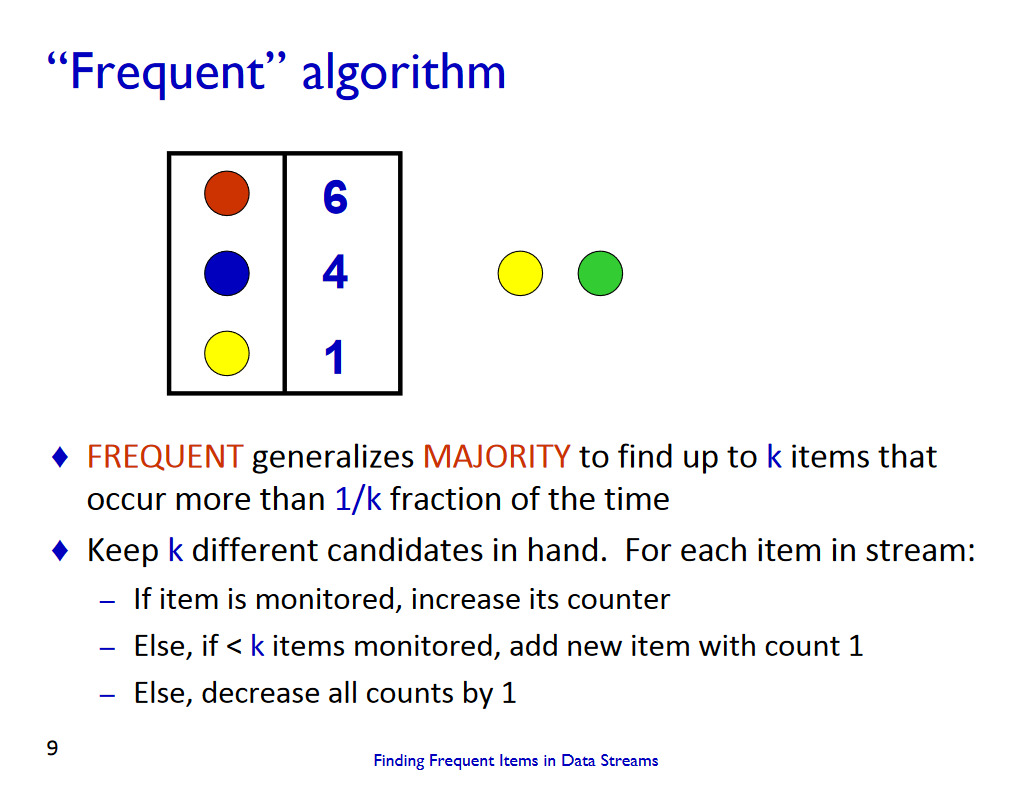

In [29]:
from IPython.display import Image
Image("1.jpeg")

![title](1.jpeg)

As we have explained before Count Min algorithm is not accurate because the huge number of Unique Ips. (If we use greater number of hash functions, we could decrease these collisions but we would use more memories.) Therefore we have created another objcet to find out frequencies easier.

Logic of the algorithm is more clear as it is in the image above.

But again frequency of IPs is so low that, there isn't IP that appears at least in the 10% of the rows. (As we have expected actually.) Since there are not much frequent IPs in the stream (which is greater than 1), our list of frequent items are just containing a list of 1's